In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

Datos de prueba cargados:
X_test shape: (504, 16000), dtype: float32
y_test shape: (504, 2), dtype: float32
Entrada esperada: <class 'numpy.int8'>, Salida esperada: <class 'numpy.int8'>
Precisión (Accuracy): 0.7440
Precisión (Precision): 0.7173
Sensibilidad (Recall): 0.8056
F1-Score: 0.7589


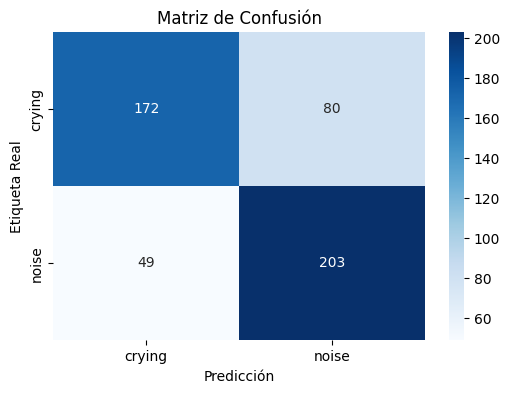

In [7]:
# Rutas
TFLITE_PATH = "../models/compressed_int8/model_NN.tflite"
TEST_DATA_PATH = "../data_train/processed_audio/test.npz"

# Cargar datos de prueba
test_data = np.load(TEST_DATA_PATH)
X_test, y_test = test_data["X"], test_data["y"]

# Verificar forma y tipo de los datos
print(f"Datos de prueba cargados:")
print(f"X_test shape: {X_test.shape}, dtype: {X_test.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")

# Cargar modelo TFLite
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

# Obtener detalles de entrada/salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Verificar tipo de entrada esperado
input_dtype = input_details[0]['dtype']
output_dtype = output_details[0]['dtype']
print(f"Entrada esperada: {input_dtype}, Salida esperada: {output_dtype}")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Convertir etiquetas de One-Hot Encoding a valores enteros
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)  # Convertir de [0,1] o [1,0] a 0 o 1
# Realizar inferencias sobre el conjunto de prueba
y_pred = []
for i in range(len(X_test)):
    input_data = X_test[i]

    # Si el modelo espera `int8`, convertir la entrada de `float32` a `int8`
    if input_dtype == np.int8:
        input_data = (input_data * 127).astype(np.int8)

    # Ejecutar inferencia
    interpreter.set_tensor(input_details[0]['index'], [input_data])
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Obtener la clase predicha
    predicted_class = np.argmax(output_data)
    y_pred.append(predicted_class)

# Convertir a array de NumPy
y_pred = np.array(y_pred)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="binary")  # "binary" porque es clasificación binaria
recall = recall_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar métricas
print(f"Precisión (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Sensibilidad (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Mostrar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["crying", "noise"], yticklabels=["crying", "noise"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()